In [1]:
import os
from typing import List, Union

import cv2
import lmdb
import numpy as np
import pyarrow as pa
import torch
from torch.utils.data import Dataset
from PIL import Image


In [2]:
lmdb_dir="/shared/s2/lab01/dataset/refseg/ETRIS/datasets/lmdb/refcoco/train.lmdb"
env = lmdb.open(lmdb_dir,
                             subdir=os.path.isdir(lmdb_dir),
                             readonly=True,
                             lock=False,
                             readahead=False,
                             meminit=False)

In [3]:
def loads_pyarrow(buf):
    """
    Args:
        buf: the output of `dumps`.
    """
    return pa.deserialize(buf)

In [4]:
with env.begin(write=False) as txn:
    keys = loads_pyarrow(txn.get(b'__keys__'))

/home/s2/donggeunkim/miniconda3/envs/etris/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
with env.begin(write=False) as txn:
    byteflow = txn.get(keys[0])

In [6]:
ref = loads_pyarrow(byteflow)


/home/s2/donggeunkim/miniconda3/envs/etris/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
ori_img = cv2.imdecode(np.frombuffer(ref['img'], np.uint8),
                               cv2.IMREAD_COLOR)

In [47]:
ori_img.shape

(640, 427, 3)

In [10]:
img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)

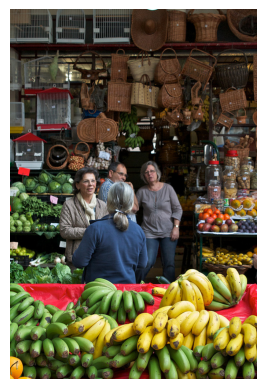

In [11]:
import matplotlib.pyplot as plt

# 이미지 표시
plt.imshow(img)
plt.axis('off')  # 이미지 축 제거
plt.show()

In [21]:
def getTransformMat( img_size, inverse=False):
    ori_h, ori_w = img_size
    inp_h, inp_w = (480,480)
    scale = min(inp_h / ori_h, inp_w / ori_w)
    new_h, new_w = ori_h * scale, ori_w * scale
    bias_x, bias_y = (inp_w - new_w) / 2., (inp_h - new_h) / 2.

    src = np.array([[0, 0], [ori_w, 0], [0, ori_h]], np.float32)
    dst = np.array([[bias_x, bias_y], [new_w + bias_x, bias_y],
                    [bias_x, new_h + bias_y]], np.float32)

    mat = cv2.getAffineTransform(src, dst)
    if inverse:
        mat_inv = cv2.getAffineTransform(dst, src)
        return mat, mat_inv
    return mat, None

In [22]:
img_size = img.shape[:2]

In [23]:
mat, mat_inv = getTransformMat(img_size, True)

In [24]:
mask = cv2.imdecode(np.frombuffer(ref['mask'], np.uint8),
                                cv2.IMREAD_GRAYSCALE)

In [26]:
mask = cv2.warpAffine(mask,
                                  mat,
                                  (480,480),
                                  flags=cv2.INTER_LINEAR,
                                  borderValue=0.)

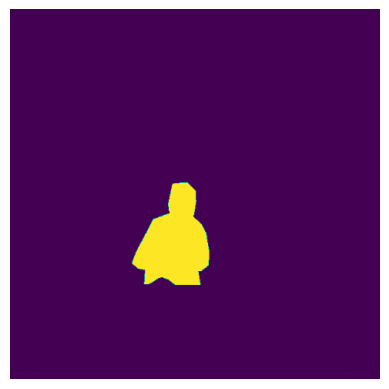

In [41]:
# 이미지 표시
plt.imshow(mask)
plt.axis('off')  # 이미지 축 제거
plt.show()

In [36]:
from collections import Counter
Counter(mask.flatten().tolist())

Counter({0: 221878,
         215: 54,
         255: 8212,
         44: 8,
         88: 12,
         114: 9,
         171: 15,
         14: 13,
         128: 59,
         181: 12,
         40: 55,
         141: 7,
         74: 14,
         84: 12,
         167: 9,
         211: 6,
         229: 7,
         26: 6,
         241: 12})

In [40]:
Counter((mask/255.).flatten().tolist())

Counter({0.0: 221878,
         0.8431372549019608: 54,
         1.0: 8212,
         0.17254901960784313: 8,
         0.34509803921568627: 12,
         0.4470588235294118: 9,
         0.6705882352941176: 15,
         0.054901960784313725: 13,
         0.5019607843137255: 59,
         0.7098039215686275: 12,
         0.1568627450980392: 55,
         0.5529411764705883: 7,
         0.2901960784313726: 14,
         0.32941176470588235: 12,
         0.6549019607843137: 9,
         0.8274509803921568: 6,
         0.8980392156862745: 7,
         0.10196078431372549: 6,
         0.9450980392156862: 12})

In [43]:
mask = mask/255.
annot = np.zeros(mask.shape)
annot[mask == 1] = 1

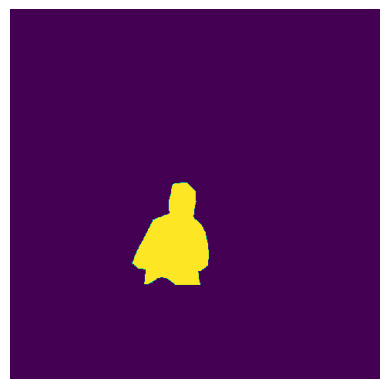

In [44]:
# 이미지 표시
plt.imshow(annot)
plt.axis('off')  # 이미지 축 제거
plt.show()

In [46]:
Counter(annot.flatten())

Counter({0.0: 222188, 1.0: 8212})

In [48]:
annot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
masked_img = original_img * m[None, None, ...] + (1 - m[None, None, ...]) * pixel_mean